In [1]:
# basic
import sys
import os

# common
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
import pickle
from mpl_toolkits.basemap import Basemap

#lib
from lib.calibration import *
from lib.predictor_definition_building import *
from lib.PCA_predictor_sst_mld import PCA_EstelaPred_sea_mask, Plot_EOFs_EstelaPred, standardise_predictor_prep
from lib.mda import Normalize, DeNormalize
from lib.plots_kma import plot_3D_kmeans, plot_scatter_kmeans, plot_grid_kmeans
from lib.plots_base import basemap_ibtracs, basemap_var, basemap_scatter, axplot_basemap, basemap_scatter_both
from lib.plots_dwts import colorp, custom_colorp, Plot_DWTs_Mean_Anom, Plot_DWTs_totalmean,\
Plot_Probs_WT_WT, Plot_Probs_WT_WT_anomaly, Plot_Probs_WT_WT_WT, Plot_DWTs_Probs, \
Report_Sim_oneyear, Report_Sim, Plot_DWTs_counts, Chrono_dwts_tcs, Chrono_probs_tcs, Plot_dwts_colormap
from lib.plots_tcs import get_storm_color, get_category, Plot_DWTs_tracks
from lib.plots_aux import data_to_discret, colors_dwt
from lib.extract_tcs import Extract_Rectangle, dwt_tcs_count, dwt_tcs_count_tracks

import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

ModuleNotFoundError: No module named 'lib.calibration'

<br>
<br>
<br>

#  <font color='navy'>**4. Statistical Downscaling Method** </font> 

>4.1 [Daily Weather Types (DWTs) classification](#dwt) <br> <br>
>>4.1.1 [Principal Component Analysis (PCA)](#pca)<br> <br>
4.1.2 [K-means clustering](#km)<br> <br>
4.1.3 [DWTs plotting](#plot)<br> <br>
4.1.4 [DWTs plotting with predictand variables](#plotp)<br> <br>
>>
4.2 [DWTs chronology, seasonality and temporal variability](#chrono) <br> <br>
4.3 [Relationship predictor-predictand](#pp)<br> <br>
>>4.3.1 [DWTs storm frequency and track counting](#count)<br> <br>
4.3.2 [Calibration time period prdictand plotting](#cali)<br> <br>
>>












<br />
<br />

## <font color='royalblue'>**4.1 Daily Weather Types (DWTs) classification**</font> <a name="dwt"></a>

<br />

**A weather type approach is proposed.**<br>
**The index predictor is first partioned into a certain number of clusters, DWTS, obtained combining three data mining techniques.**<br><br><br>

<br />

### <font color='cornflowerblue'>**4.1.1 Principal Component Analysis (PCA)**</font> <a name="pca"></a>

<br />

**The PCA is employed to reduce the high dimensionality of the original data space and thus simplify the classification process, transforming the predictor fields into spatial and temporal modes.**

**PCA projects the original data on a new space searching for the maximum variance of the sample data.**<br>
**The first 237 PCs are captured, which explain the 90 % of the variability as shown:**

In [2]:
path_p = r'/home/administrador/Documentos/seasonal/seasonal_forecast/new/'
xs = xr.open_dataset(path_p+'xs_index_vars_19822019_2deg_new.nc')
df = pd.read_pickle(path_p+'df_coordinates_pmin_sst_mld_2019.pkl')
xs_trmm = xs_trmm = xr.open_dataset(path_p+'xs_trmm_1982_2019_2deg_new.nc')


In [3]:
# predictor area
lo_area = [160, 210]
la_area = [-30, 0]

In [4]:
# PCA parameters
ipca, xds_PCA = PCA_EstelaPred_sea_mask(xs, ['index']) #ipca son las componentes principales, las 416 que salen
xds_PCA

<xarray.Dataset>
Dimensions:        (lat: 16, lon: 26, n_components: 416, n_features: 416, n_points: 416, time: 13879)
Coordinates:
  * lon            (lon) float64 160.2 162.2 164.2 166.2 ... 206.2 208.2 210.2
  * lat            (lat) float64 -0.25 -2.25 -4.25 ... -26.25 -28.25 -30.25
Dimensions without coordinates: n_components, n_features, n_points, time
Data variables:
    PCs            (time, n_components) float64 6.68 -0.6377 ... -0.5949 0.2736
    EOFs           (n_components, n_features) float64 -0.01639 ... -0.04297
    variance       (n_components) float64 131.6 25.35 15.47 ... 0.1448 0.1397
    pred_mean      (n_features) float64 0.54 0.5337 0.52 ... 0.1504 0.09442
    pred_std       (n_features) float64 0.2995 0.3035 0.3018 ... 0.189 0.1484
    pred_time      (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2019-12-31
    pred_data_pos  (n_points) bool True True True True ... True True True True
Attributes:
    method:     gradient + estela + sea mask
    pred_name:  ['index']

**PCA projects the original data on a new space searching for the maximum variance of the sample data.**<br>
**The first 237 PCs are captured, which explain the 90 % of the variability as shown:**

<br><br>

### <font color='cornflowerblue'>**4.1.2 K-means clustering**</font> <a name="km"></a>

<br>

**Daily synoptic patterns of the index predictor are obtained using the K-means clustering algorithm. It divides the data space into 49 clusters, a number that which must be a compromise between an easy handle characterization of the synoptic patterns and the best reproduction of the variability in the data space. Previous works with similar anlaysis confirmed that the selection of this number is adequate <a href="https://www.researchgate.net/profile/Christie-Hegermiller-2/publication/322103268_Multiscale_climate_emulator_of_multimodal_wave_spectra_MUSCLE-spectra/links/5a453d2aaca272d2945dacc2/Multiscale-climate-emulator-of-multimodal-wave-spectra-MUSCLE-spectra.pdf" target="_blank">(Rueda et al. 2017)</a>.**
<br>

**Each cluster is defined by a prototype and formed by the data for which the prototype is the nearest.**

**Finally the best match unit (bmus) of daily clusters are reordered into a lattice following a geometric criteria, so that similar clusters are placed next to each other for a more intuitive visualization.**

In [5]:
# PCA data
variance = xds_PCA.variance.values[:]
EOFs = xds_PCA.EOFs.values[:]
PCs = xds_PCA.PCs.values[:]

var_anom_std = xds_PCA.pred_std.values[:]
var_anom_mean = xds_PCA.pred_mean.values[:]
time = xds_PCA.time.values[:]

variance = xds_PCA.variance.values
percent = variance / np.sum(variance)*100
percent_ac = np.cumsum(percent)
n_comp_95 = np.where(percent_ac >= 95)[0][0]
n_comp_90 = np.where(percent_ac >= 90)[0][0]
    
# plot
n_comp = n_comp_90

nterm = n_comp_90 + 1 #n_comp_90 es el número de PC que explican el 90% de la varianza, que en este caso son 237
PCsub = PCs[:, :nterm]
EOFsub = EOFs[:nterm, :]

# normalization
data = PCsub
data_std = np.std(data, axis=0)
data_mean = np.mean(data, axis=0)

In [6]:
xds_kma_ord,xds_kma = func_kma_order(path_p,xds_PCA,xs)

Kma order obtained:  [11 27 28 45 16 23 47 19  7 14  0 31 46 30 34 35 15  2  8 33 37 41  5 10
 48  4 40 21  3 20 42 29 38 26 32 43 13 17 18 39 25 22 44  9  1 24  6 12
 36]


In [66]:
xds_kma_sel = trmm_kma(xds_kma,xs_trmm)

### <font color='cornflowerblue'>**4.1.3 DWTs plotting**</font> <a name="plot"></a>

<br />

In [6]:
#load
xds_kma = xr.open_dataset(path_p+'kma_model/xds_kma_index_vars_1b.nc')

In [7]:
path_st = r'/home/administrador/Documentos/'
xds_ibtracs, xds_SP = storms_sp(path_st)

All basins storms:  13481
SP basin storms:    1130 



In [9]:
st_bmus,st_lons,st_lats, st_categ = st_bmus(xds_SP,xds_kma)

In [9]:
# custom colorbar for index
color_ls = ['white','cyan','cornflowerblue','darkseagreen','olivedrab','gold','darkorange','orangered','red','deeppink','violet','darkorchid','purple','midnightblue']
custom_cmap = custom_colorp(color_ls)

<br>

**DWTs lattice and corresponding colors:**

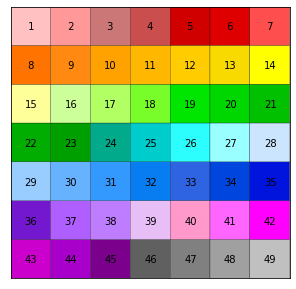

In [11]:
fig_dwt_lattice = Plot_dwts_colormap(xds_kma.n_clusters.size)

<br>

**The resulting clustering of the index predictor, each cell is the mean of all the patterns of the corresponding cluster:**

index: min(0.0)  max(1.0)


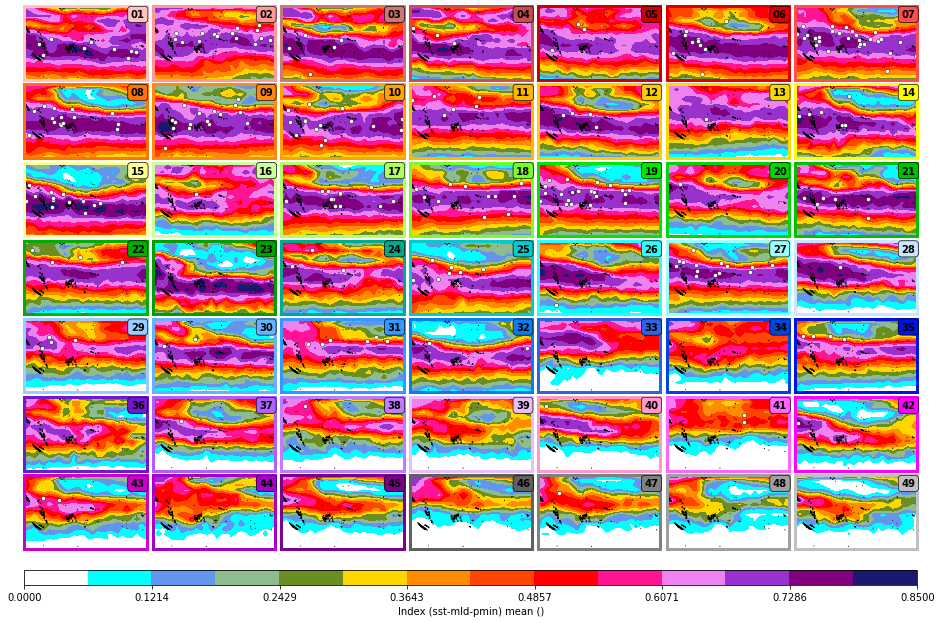

In [12]:
fig = Plot_DWTs_Mean_Anom(xds_kma, xs, ['index'], minis=[0], maxis=[.85],levels=[len(color_ls)], kind='mean',cmap = [custom_cmap],genesis='on', st_bmus=st_bmus, 
                          st_lons=st_lons, st_lats=st_lats, markercol='white', markeredge='k');

<br />
<br />

### <font color='cornflowerblue'>**4.1.4 DWTs plotting with predictand variables**</font> <a name="plotp"></a>

<br />

**DWTs - SST and MLD Mean:**

sst: min(14.899999618530273)  max(33.0)
dbss: min(7.5)  max(330.0)


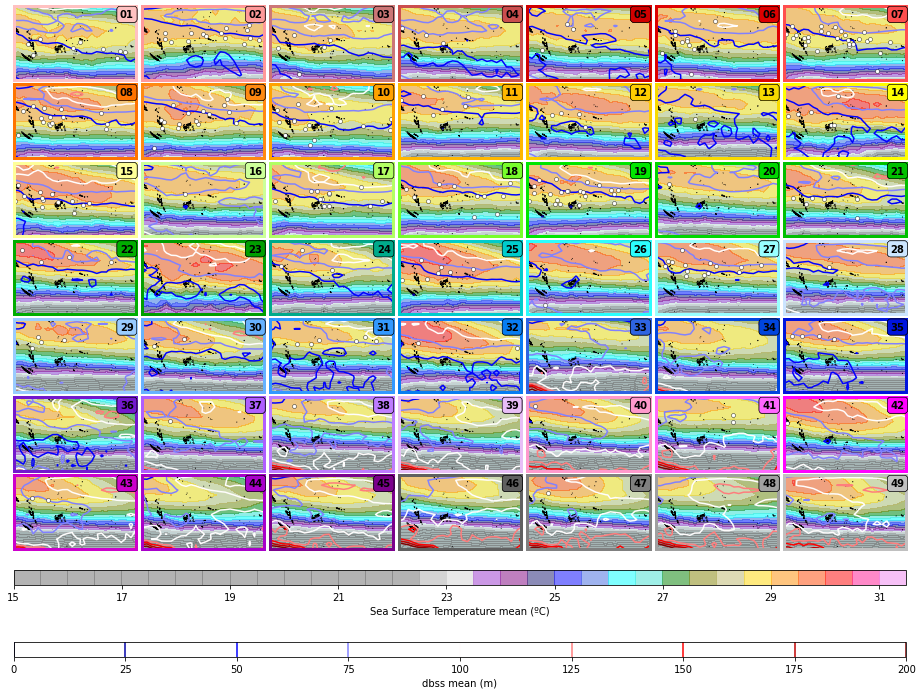

In [23]:
fig = Plot_DWTs_Mean_Anom(xds_kma, xs, ['sst', 'dbss'], minis=[22, 0], maxis=[32, 200], levels=[(32-22)/0.5, 8], kind='mean', 
                          cmap=[colorp(), 'seismic'], genesis='on', st_bmus=st_bmus, st_lons=st_lons, st_lats=st_lats, markercol='white', markeredge='k');

<br> <br>

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: rgb(0,0,0); background-color: #fcf8e3; border-color: #faebcc; ">
    
**Clear patterns can be extracted from these figures related to TCs genesis. Most of it takes place under the following conditions:**   
* SST interval from 28ºC to 30ºC (specially 28.5 to 29.5 ºC) that correspond to positive or zero SST anomalies.
* MLD values equal or smaller to 75 m that correspond to negative anomalies.
    
</div>

<br />
<br />

## <font color='royalblue'>**4.2 DWTs seasonality, annual variability and chronology**</font> <a name="chrono"></a>

<br />

**Several plots are shown to better analyse the distribution of DWTs, their transition, persistence and conditioning to TCs occurrence and to AWT.**

In [48]:
path_mjo_awt = r'/home/administrador/Documentos/STORMS_VIEWER/'

In [49]:
awt,mjo,awt0 = awt_mjo_ds(path_mjo_awt)

<br>

**Seasonality:**

In [60]:
bmus_DWT, bmus_time,awt0_sel_bmus,bmus_AWT,bmus_MJO = bmus_dwt_mjo(mjo,awt,awt0,xds_kma)

**TCs genesis according to month:**
<br>

![TITLE](st0.png)

In [13]:
#all categories
xs_dwt_counts = dwt_tcs_count_tracks(xds_kma, df, dx=8, dy=8, lo0=lo_area[0], lo1=lo_area[1], la0=la_area[0], la1=la_area[1])
xs_dwt_counts.to_netcdf(r'/home/administrador/Documentos/seasonal/seasonal_forecast/new/kma_model/xds_count_tcs8.nc')

#category 3 
xs_dwt_counts_964 = dwt_tcs_count_tracks(xds_kma, df, dx=8, dy=8, categ=965,lo0=lo_area[0], lo1=lo_area[1], la0=la_area[0], la1=la_area[1])
xs_dwt_counts_964.to_netcdf(r'/home/administrador/Documentos/seasonal/seasonal_forecast/new/kma_model/xds_count_tcs8_964.nc')

# category 2
xs_dwt_counts_979 = dwt_tcs_count_tracks(xds_kma, df, dx=8, dy=8, categ=979,lo0=lo_area[0], lo1=lo_area[1], la0=la_area[0], la1=la_area[1])
xs_dwt_counts_979.to_netcdf(r'/home/administrador/Documentos/seasonal/seasonal_forecast/new/kma_model/xds_count_tcs8_979.nc')

In [7]:
xs_dwt_counts = xr.open_dataset(path_p+'kma_model/xds_count_tcs8.nc')
xs_dwt_counts_964 = xr.open_dataset(path_p+'kma_model/xds_count_tcs8_964.nc')
xs_dwt_counts_979 = xr.open_dataset(path_p+'kma_model/xds_count_tcs8_979.nc')

In [8]:
xds_timeline = ds_timeline(df,xs_dwt_counts,xs_dwt_counts_964,xds_kma)

In [10]:
mask_bmus_YD, mask_tcs_YD = variables_dwt_super_plot(xds_kma, xds_timeline)

<br>

**AWT transferred to the DWTs:**

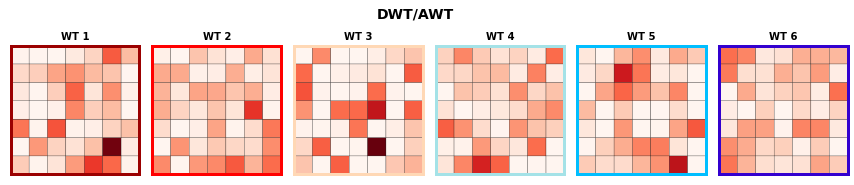

In [62]:
n_clusters_AWT = 6
n_clusters_DWT = 49
n_clusters_MJO = 8
fig = Plot_Probs_WT_WT(bmus_AWT, bmus_DWT, n_clusters_AWT, n_clusters_DWT, ttl = 'DWT/AWT',height = 15, width = 3, wt_colors=True)

fig = Plot_DWTs_Probs(bmus_DWT, bmus_time, 49, height=10, width=18);

<br>

![TITLE](s.png)

<br> 

**Chronology during all the calibration period, with the AWT on the left and the TC days included as black dots:**

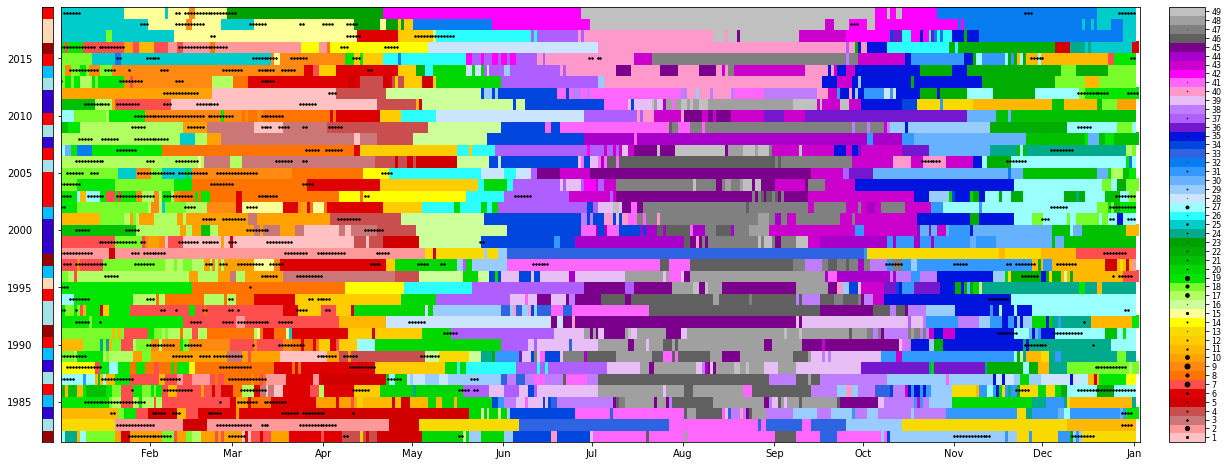

In [22]:
fig = Chrono_dwts_tcs(xds_kma, mask_bmus_YD, mask_tcs_YD, awt0_sel_bmus);

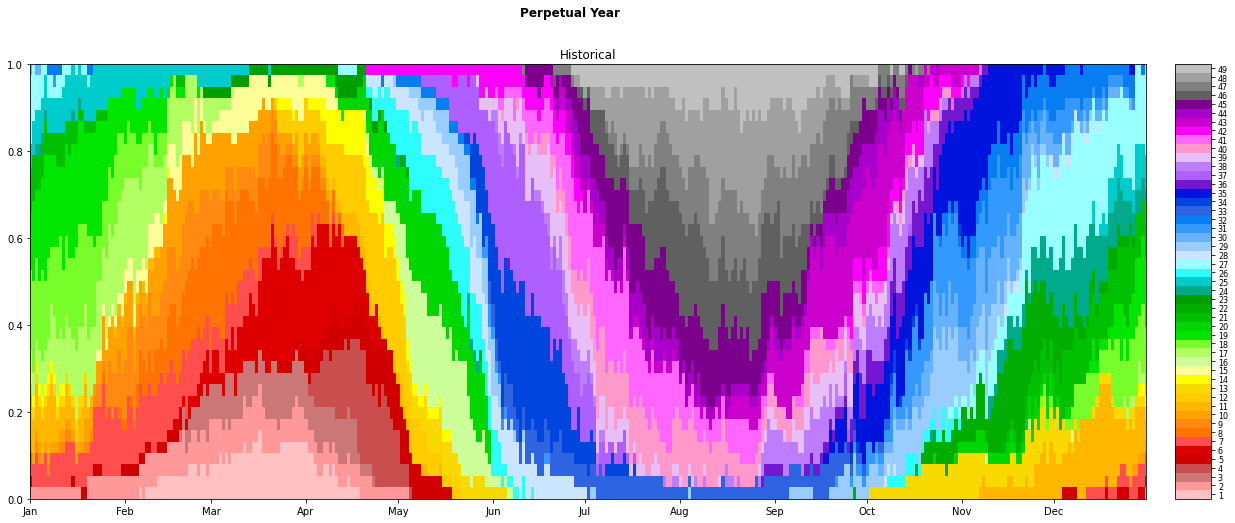

In [63]:
fig = Report_Sim(xds_kma, py_month_ini=1);

<br> 

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: rgb(0,0,0); background-color: #fcf8e3; border-color: #faebcc; ">
    
**During the TC season months (November, December, January, February, March and April) the DWTs proability is focused on the upper half of the upper part of the lattice, where most of the TC genesis is also concentrated. In the most intense months (January, February and March) DWTs with the highest number of TCs genesis points are especially likely. On the contrary, in the rest of the months, the probability is shared amongst the DWTs of the lower half of the lattice, where there is very few or null TC genesis activity.**
    
</div>

<br> 

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: rgb(0,0,0); background-color: #fcf8e3; border-color: #faebcc; ">
    
**Intra annual variability:**
 * Months out of the TCs season: purple, pink, gray and blue -> DWTs from 29 to 49 -> low or null TCs genesis activity
 * Months out of the TCs season: green, orange, red, yellow -> DWTs from 1 to 28 -> high TCs genesis acitvity
    
    
</div>

<br> 

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: rgb(0,0,0); background-color: #fcf8e3; border-color: #faebcc; ">
    
**Interanual varibility:**
 * **El Niño**: not much variability, high TC activity (DWTs like 6 or 18 are very probable), 1997 is the year when the season starts earlier (October) and ends later (June)
 * Other factors influences such as long-terms trends, maybe associated to SST warming during this time period.  
    
</div>

<br />
<br />

## <font color='royalblue'>**4.3 Relationship predictor-predictand**</font> <a name="pp"></a>

<br />

### <font color='cornflowerblue'>**4.3.1 DWTs storm frequency and track counting**</font> <a name="count"></a>

<br />

**DWTs - TCs tracks according to genesis**

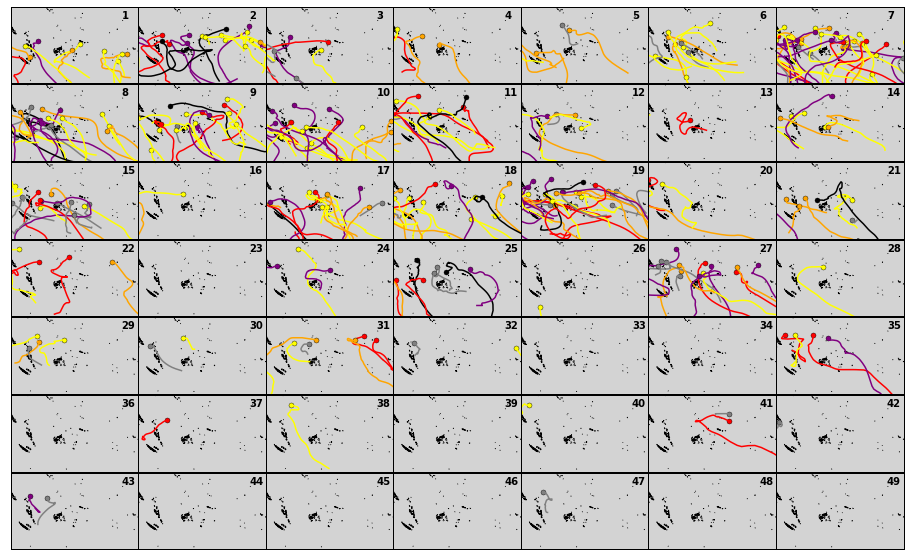

In [17]:
fig = Plot_DWTs_tracks(xds_kma, xs, st_bmus, st_lons, st_lats, st_categ, mode='genesis', cocean='lightgray');

**The predictor area is discretized in <u> 8º cells</u> to compute the storm frequency per DWT.**

**Absolute number of TCs per DWT:**

counts_tcs: min(1.0)  max(13.0)


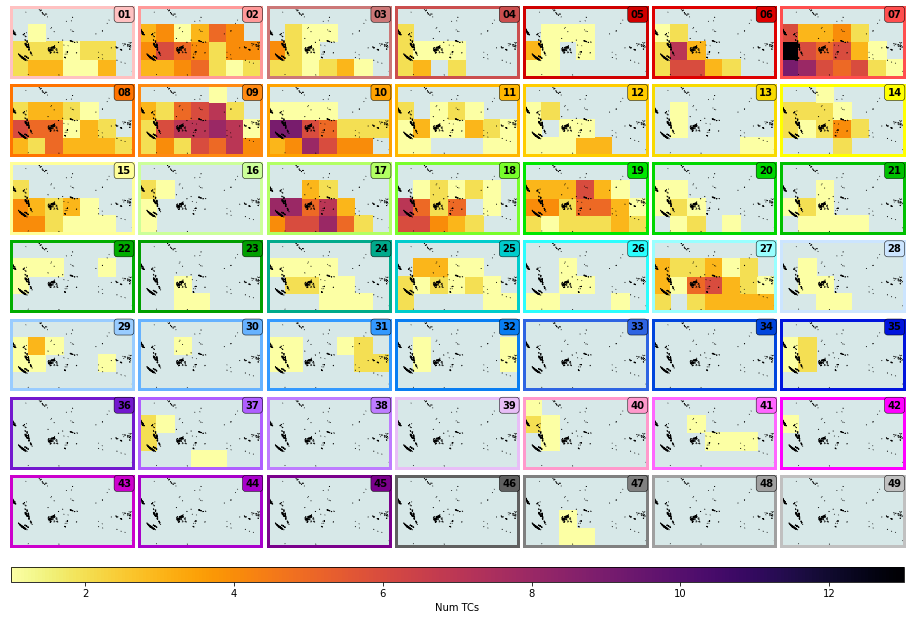

In [15]:
fig_8 = Plot_DWTs_counts(xs_dwt_counts, mode='counts_tcs');

<br>

**Number of TCs per day conditioned to each DWT:**

tcs_dwts: min(0.002403846153846154)  max(0.037142857142857144)


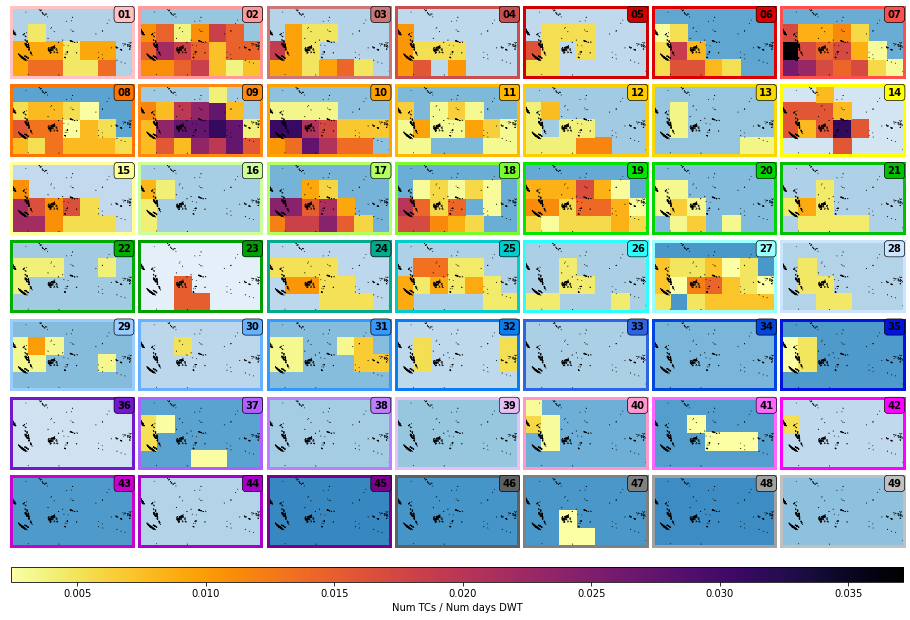

In [17]:
fig_8 = Plot_DWTs_counts(xs_dwt_counts, mode='tcs_dwts');

<br />
<br />

### <font color='cornflowerblue'>**4.3.2 Calibration time period predictand plotting**</font> <a name="cali"></a>

<br> 

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: rgb(0,0,0); background-color: #fcf8e3; border-color: #faebcc; ">
    
**Recall:**
 * Generation of the index predictor.
 * Clustering of the index predictor in 49 synoptic patterns named DWTs.
 * Calculation of the number of TCs per day conditioned to each DWT in 8x8º cells in the target area. 
    

<br>   
    
**-> Each day of the calibration period has therefore its <u>expected number of TCs map.</u>**
    
</div>

In [19]:
xds_timeline = ds_timeline(df,xs_dwt_counts,xs_dwt_counts_964,xds_kma)

<br>

**This daily number of TCs in 3x3º cells is aggregated in monthly basis for an easy management and visualization.**


In [9]:
# resample months
xds_timeM0 = xds_timeline.resample(time='MS', skipna=True).sum()
del xds_timeM0['bmus']
xds_timeM = xds_timeM0.where(xds_timeM0.probs_tcs > 0, np.nan)
#xds_timeM.to_netcdf(path_p+'xds_timeM8.nc')
xds_timeM

<xarray.Dataset>
Dimensions:         (lat: 5, lon: 8, time: 456)
Coordinates:
  * time            (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
  * lat             (lat) int64 -30 -22 -14 -6 2
  * lon             (lon) int64 160 168 176 184 192 200 208 216
Data variables:
    mask_tcs        (time, lat, lon) float64 8.0 8.0 8.0 8.0 ... nan nan nan nan
    counts_tcs      (time, lat, lon) float64 99.0 100.0 120.0 ... nan nan nan
    counts_tcs_964  (time, lat, lon) float64 10.0 19.0 22.0 17.0 ... nan nan nan
    probs_tcs       (time, lat, lon) float64 0.3036 0.3154 0.3822 ... nan nan
    probs_tcs_964   (time, lat, lon) float64 0.02865 0.05969 0.07171 ... nan nan

<br>

**Expected mean number of TCs in 8x8º cells in the target area for the calibration time period (1982-2019):**

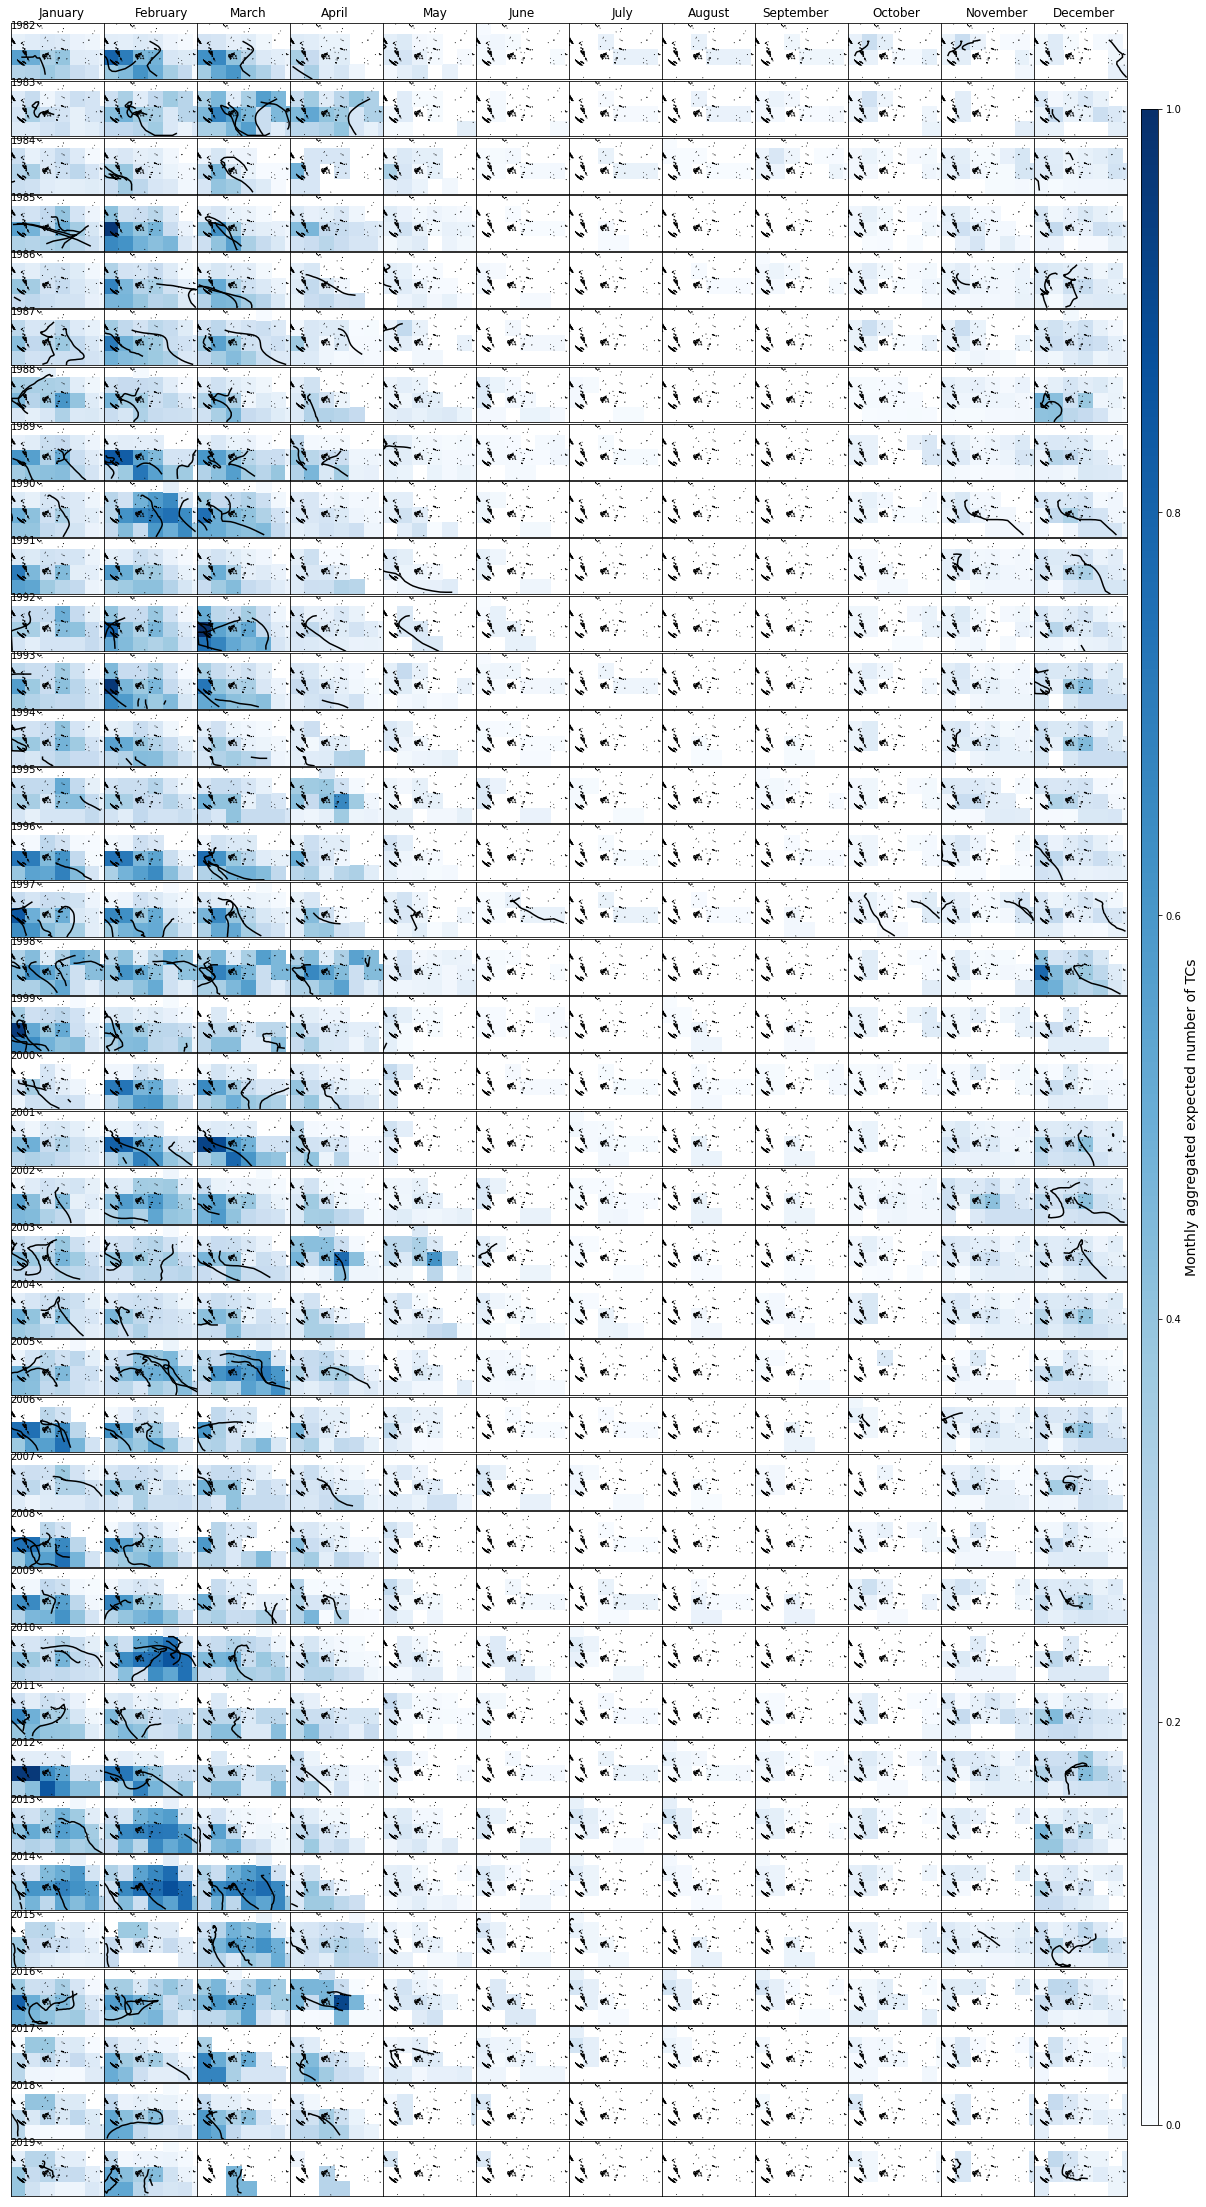

In [23]:
fig_cali_8 = plot_calibration_period(xds_timeM,xds_timeline,df,1)

<br>

**Expected number of TCs reaching category 3 or greater in 8x8º cells in the target area for the calibration time period (1982-2019):**

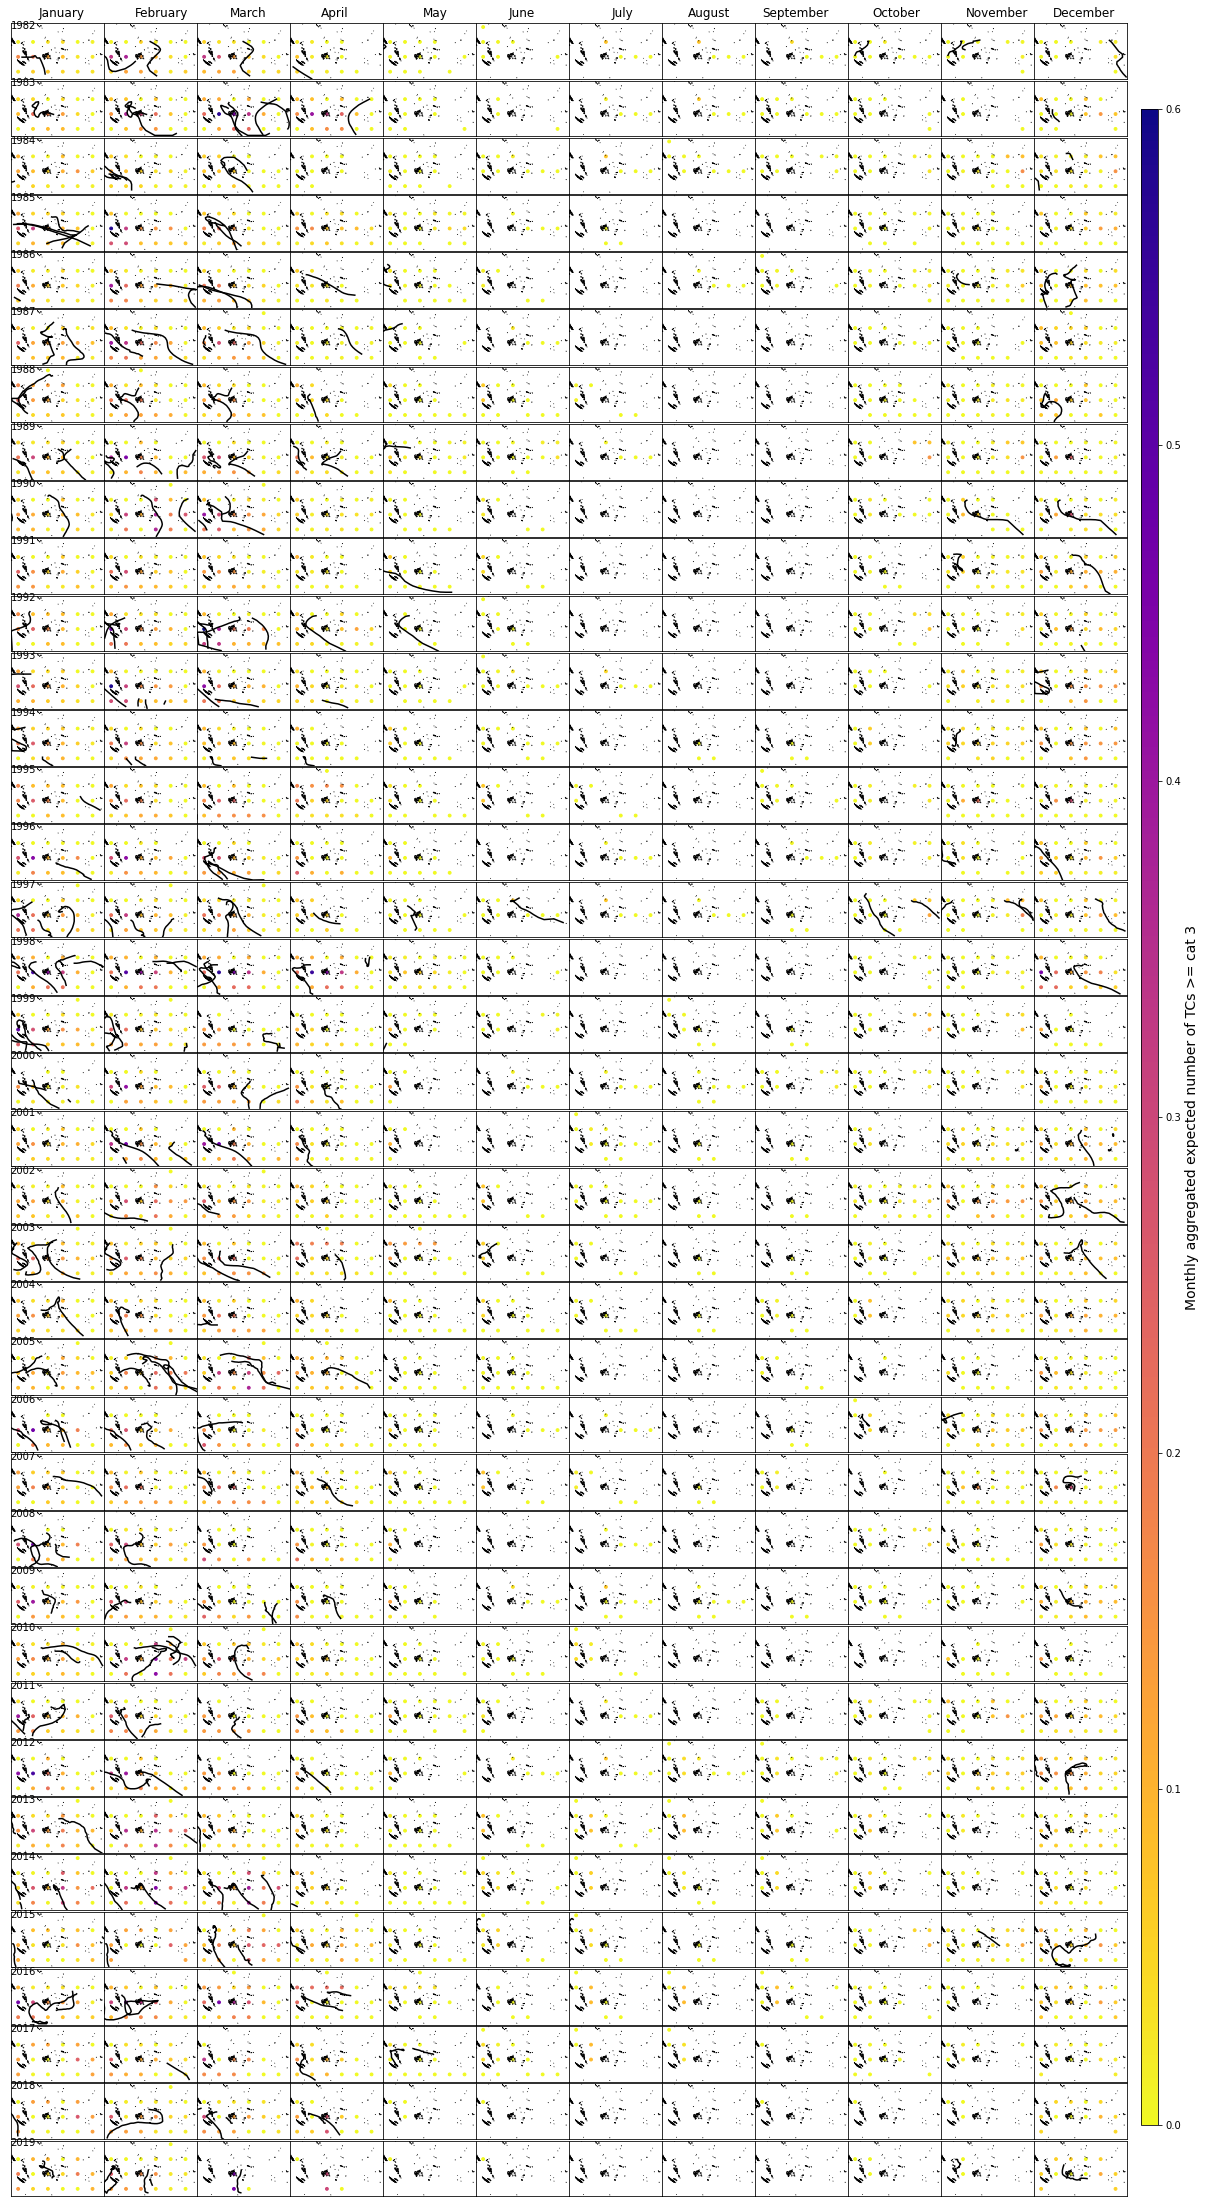

In [12]:
fig_cali_8 = plot_calibration_period_cat3(xds_timeM,xds_timeline,df,0.6,8)

<br>

**Expected number of TCs in 8x8º cells in the target area for year 2015 (El Niño) of the calibration time period (1982-2019):**

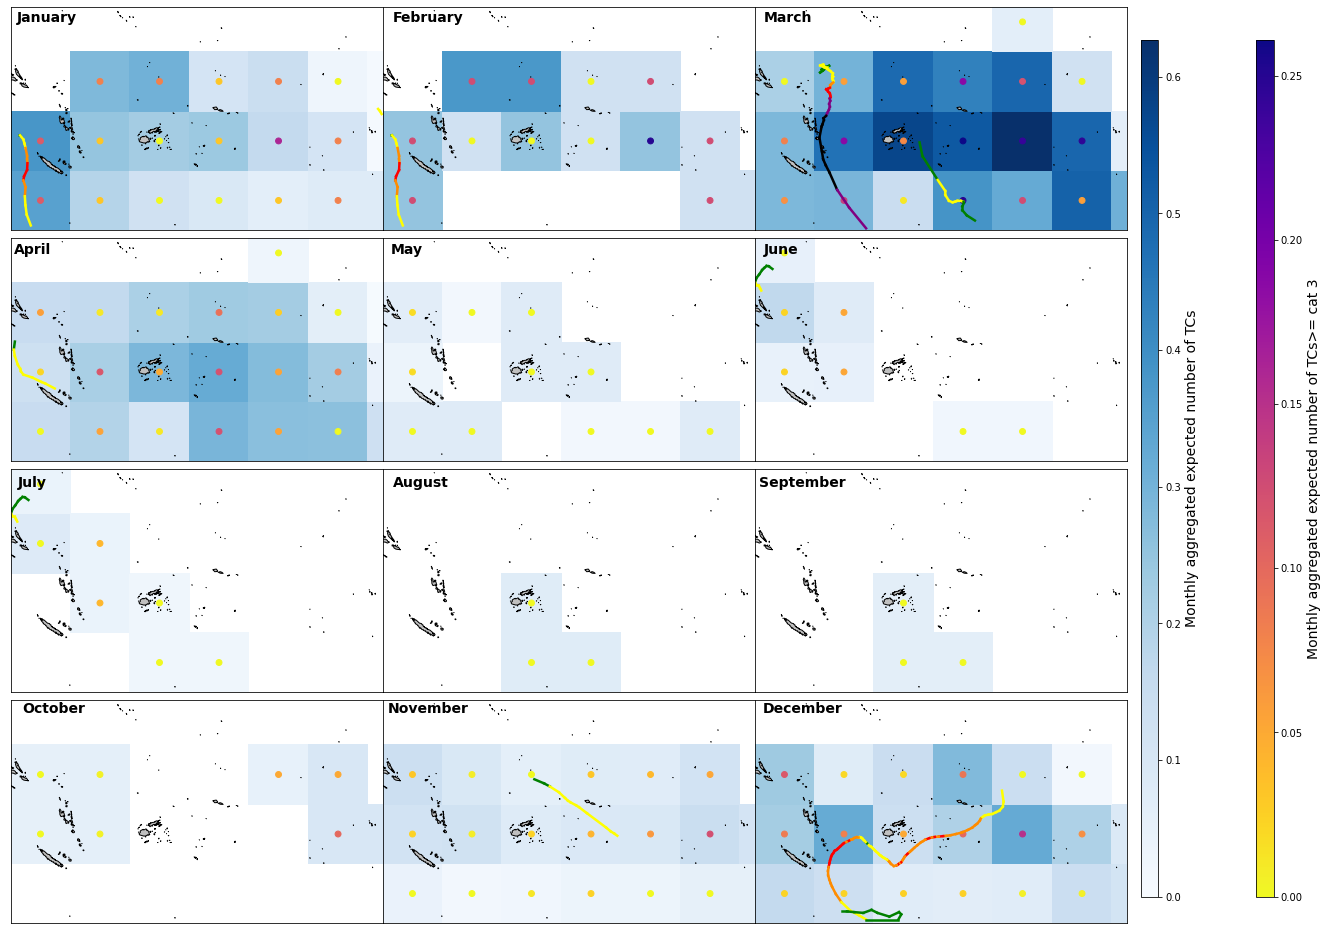

In [10]:
fig_year_8 = plot_cali_year(2015,xds_timeline,xds_timeM,df,35)

<br> 

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: rgb(0,0,0); background-color: #fcf8e3; border-color: #faebcc; ">
    
**The model generally performs well when estimating the expected TC activity and intensity.**
<br>
    
**However rather than reproducing exactly the historical TCs tracks it shows higher number of expected TCs in the TC path but also in the surroundings (overstimation).**
<br>
    
**In puntctual cases where the number of historical TC tracks in a cell is greater than 3 there is an understimation.**
<br>
    
**When a TC is very intense or very close in dates to the previous or following month it leaves its footprint (Pam 07/03/2015).**
   
    
</div>